# Assessment: Inteligência Artificial - Clusterização

## Setup Inicial e Download dos Datasets

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shutil
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.datasets import make_swiss_roll, fetch_olivetti_faces, fetch_20newsgroups, fetch_openml
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

### Download do Mall Customer Segmentation Dataset

In [72]:
import kagglehub

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
print("Path to dataset files:", path)

source_file = os.path.join(path, 'Mall_Customers.csv')
dest_file = '/Users/gtauber/Documents/Development/College/2025/T3/TPS/Clusterizacao/AT_Dataset/Mall_Customers.csv'

shutil.copy(source_file, dest_file)
print(f"Mall Customers copiado para AT_Dataset")

Path to dataset files: /Users/gtauber/.cache/kagglehub/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/versions/1
Mall Customers copiado para AT_Dataset


### Download do Olivetti Faces Dataset

In [73]:
path_olivetti = kagglehub.dataset_download("sahilyagnik/olivetti-faces")
print("Path to dataset files:", path_olivetti)

for file in os.listdir(path_olivetti):
    print(file)
    if file.endswith('.csv'):
        source_file = os.path.join(path_olivetti, file)
        dest_file = f'/Users/gtauber/Documents/Development/College/2025/T3/TPS/Clusterizacao/AT_Dataset/{file}'
        shutil.copy(source_file, dest_file)
        print(f"Arquivo {file} copiado para AT_Dataset")

Path to dataset files: /Users/gtauber/.cache/kagglehub/datasets/sahilyagnik/olivetti-faces/versions/1
olivetti_faces_target.npy
olivetti_faces.npy


### Download do MNIST Dataset

In [74]:
path_mnist = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Path to dataset files:", path_mnist)

for file in os.listdir(path_mnist):
    if file.endswith('.csv'):
        source_file = os.path.join(path_mnist, file)
        dest_file = f'/Users/gtauber/Documents/Development/College/2025/T3/TPS/Clusterizacao/AT_Dataset/{file}'
        shutil.copy(source_file, dest_file)
        print(f"Arquivo {file} copiado para AT_Dataset")

Path to dataset files: /Users/gtauber/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


## Questão 1: Análise Inicial - Mall Customer Segmentation Data

Avaliar o dataset e determinar os objetivos de agrupamento.

In [75]:
df_mall = pd.read_csv('/Users/gtauber/Documents/Development/College/2025/T3/TPS/Clusterizacao/AT_Dataset/Mall_Customers.csv')

print("Shape do dataset:", df_mall.shape)
print("\nPrimeiras linhas:")
df_mall.head()

Shape do dataset: (200, 5)

Primeiras linhas:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [76]:
print("Informações do dataset:")
df_mall.info()

print("\nEstatísticas descritivas:")
df_mall.describe()

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Estatísticas descritivas:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Análise dos Objetivos de Agrupamento

Baseando-se no funcionamento do K-means e na análise do dataset, os principais objetivos de agrupamento são:

1. **Segmentação de Clientes por Poder de Compra**: Agrupar clientes com base na renda anual e pontuação de gastos para identificar diferentes perfis econômicos

2. **Identificação de Padrões de Consumo**: Encontrar grupos de clientes com comportamentos similares de gastos, independente da idade ou gênero

3. **Marketing Direcionado**: Criar segmentos específicos para campanhas personalizadas baseadas nas características dos grupos

O K-means é adequado aqui pois:
- Os dados são numéricos (idade, renda, score)
- Esperamos clusters esféricos e bem separados
- O número de clientes (200) é manejável

## Questão 2: K-means Clustering

Aplicar K-means e avaliar os resultados.

In [77]:
X = df_mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dados preparados para clustering")
print(f"Shape: {X_scaled.shape}")

Dados preparados para clustering
Shape: (200, 3)


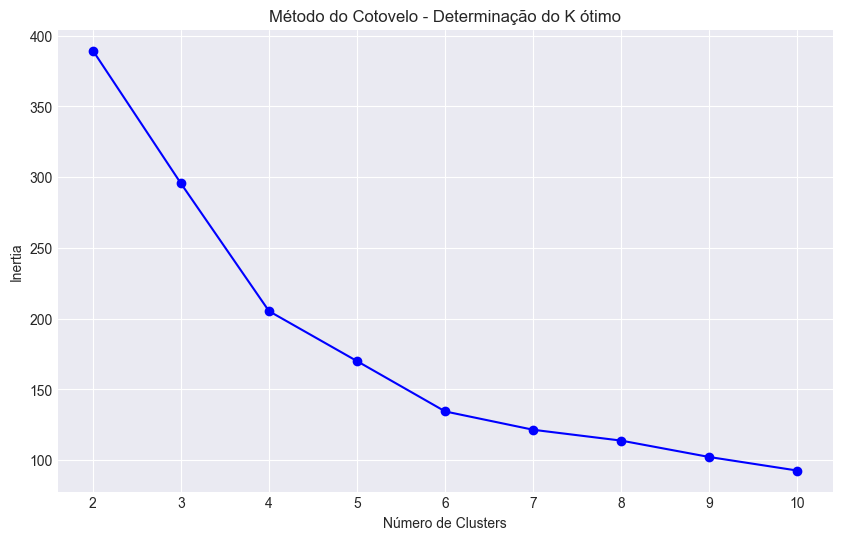

In [78]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo - Determinação do K ótimo')
plt.grid(True)
plt.show()

In [79]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_mall['Cluster'] = clusters

silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.3f}")

print("\nDistribuição dos clusters:")
print(df_mall['Cluster'].value_counts().sort_index())

Silhouette Score: 0.417

Distribuição dos clusters:
Cluster
0    20
1    54
2    40
3    39
4    47
Name: count, dtype: int64


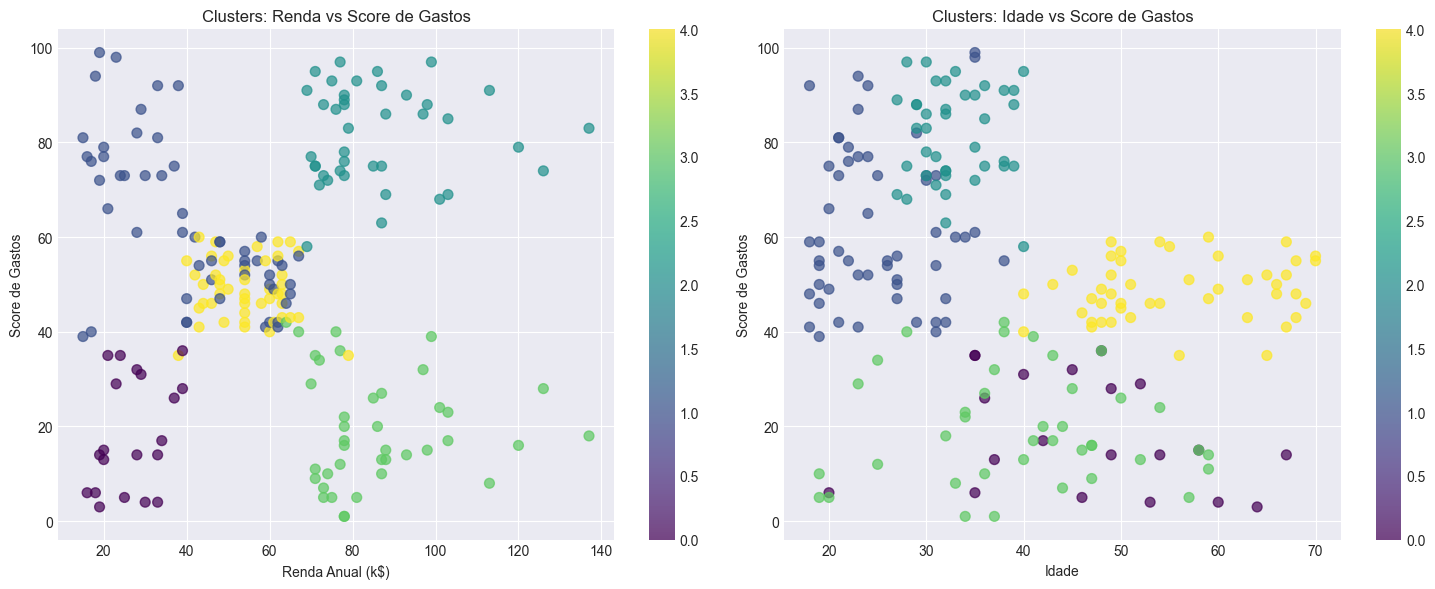

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axes[0].scatter(df_mall['Annual Income (k$)'], 
                          df_mall['Spending Score (1-100)'],
                          c=clusters, cmap='viridis', s=50, alpha=0.7)
axes[0].set_xlabel('Renda Anual (k$)')
axes[0].set_ylabel('Score de Gastos')
axes[0].set_title('Clusters: Renda vs Score de Gastos')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(df_mall['Age'], 
                          df_mall['Spending Score (1-100)'],
                          c=clusters, cmap='viridis', s=50, alpha=0.7)
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Score de Gastos')
axes[1].set_title('Clusters: Idade vs Score de Gastos')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

In [81]:
print("Características médias de cada cluster:\n")
cluster_summary = df_mall.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_summary.round(1))

Características médias de cada cluster:

          Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                  
0        46.2                26.8                    18.4
1        25.2                41.1                    62.2
2        32.9                86.1                    81.5
3        39.9                86.1                    19.4
4        55.6                54.4                    48.9


### Situações onde K-means pode falhar:

1. **Clusters não-esféricos**: K-means assume clusters de forma esférica. Falha com formas alongadas ou irregulares

2. **Tamanhos diferentes**: Clusters com densidades muito diferentes são mal identificados

3. **Outliers**: K-means é sensível a outliers que podem distorcer os centroides

4. **Número de clusters errado**: Se não soubermos o K ideal, o algoritmo pode criar divisões artificiais

5. **Dimensões com escalas diferentes**: Sem normalização, variáveis com valores maiores dominam o cálculo de distância

## Questão 3: Redução de Dimensionalidade e Quantização Vetorial

### 3a. Quantização Vetorial com K-means

In [82]:
n_clusters_vq = 8

kmeans_vq = KMeans(n_clusters=n_clusters_vq, random_state=42)
labels_vq = kmeans_vq.fit_predict(X_scaled)

X_quantized = kmeans_vq.cluster_centers_[labels_vq]

mse = np.mean((X_scaled - X_quantized) ** 2)
print(f"Erro médio quadrático da quantização: {mse:.4f}")
print(f"Número de vetores originais: {len(X_scaled)}")
print(f"Número de protótipos (clusters): {n_clusters_vq}")
print(f"Taxa de compressão: {len(X_scaled)/n_clusters_vq:.1f}:1")

Erro médio quadrático da quantização: 0.1895
Número de vetores originais: 200
Número de protótipos (clusters): 8
Taxa de compressão: 25.0:1


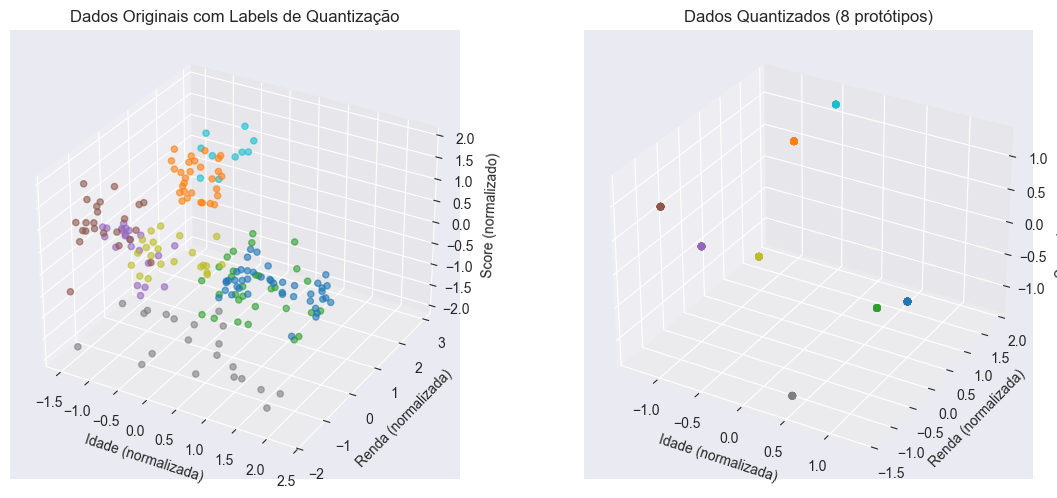

In [83]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], 
           c=labels_vq, cmap='tab10', s=20, alpha=0.6)
ax1.set_title('Dados Originais com Labels de Quantização')
ax1.set_xlabel('Idade (normalizada)')
ax1.set_ylabel('Renda (normalizada)')
ax1.set_zlabel('Score (normalizado)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_quantized[:, 0], X_quantized[:, 1], X_quantized[:, 2], 
           c=labels_vq, cmap='tab10', s=20, alpha=0.6)
ax2.set_title('Dados Quantizados (8 protótipos)')
ax2.set_xlabel('Idade (normalizada)')
ax2.set_ylabel('Renda (normalizada)')
ax2.set_zlabel('Score (normalizado)')

plt.tight_layout()
plt.show()

### 3b. PCA - Componentes Principais

In [84]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

print("Variância explicada por componente:")
for i, (var, cum_var) in enumerate(zip(explained_var_ratio, cumulative_var_ratio)):
    print(f"PC{i+1}: {var:.3f} (Acumulado: {cum_var:.3f})")

Variância explicada por componente:
PC1: 0.443 (Acumulado: 0.443)
PC2: 0.333 (Acumulado: 0.776)
PC3: 0.224 (Acumulado: 1.000)


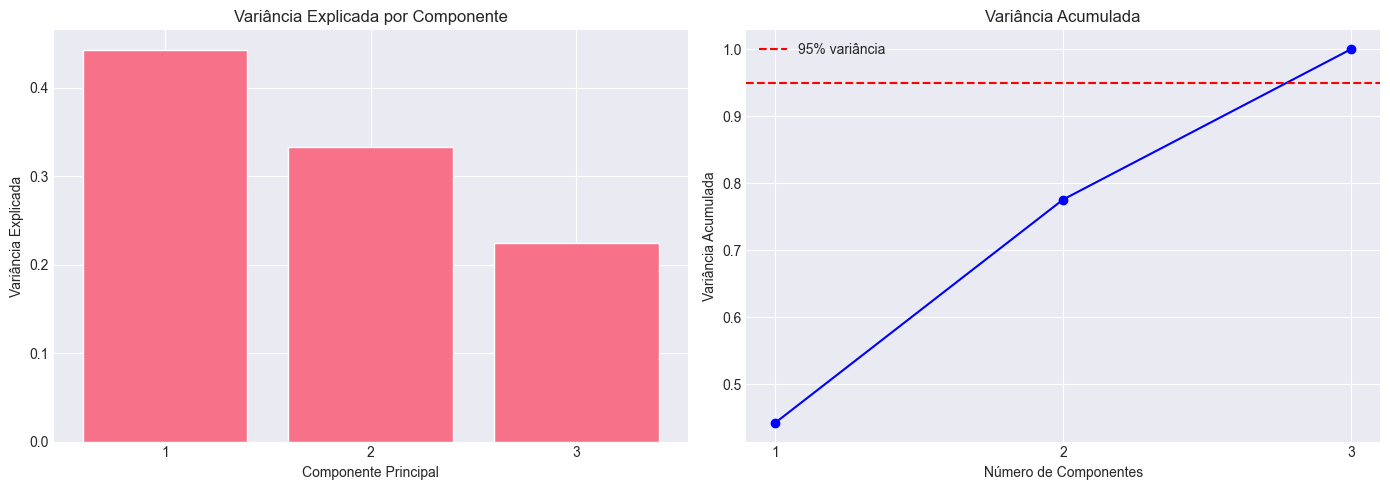

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(explained_var_ratio)+1), explained_var_ratio)
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Variância Explicada')
axes[0].set_title('Variância Explicada por Componente')
axes[0].set_xticks(range(1, len(explained_var_ratio)+1))

axes[1].plot(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio, 'bo-')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variância')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Variância Acumulada')
axes[1].set_title('Variância Acumulada')
axes[1].set_xticks(range(1, len(cumulative_var_ratio)+1))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [86]:
print("\nComponentes principais (loadings):")
feature_names = ['Idade', 'Renda Anual', 'Score de Gastos']
components_df = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)
print(components_df.round(3))


Componentes principais (loadings):
     Idade  Renda Anual  Score de Gastos
PC1  0.706       -0.048           -0.706
PC2  0.030        0.999           -0.038
PC3  0.707        0.005            0.707


### 3c. Comparação: Quantização vs PCA

In [87]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

X_reconstructed_pca = pca_2d.inverse_transform(X_pca_2d)

mse_pca = np.mean((X_scaled - X_reconstructed_pca) ** 2)
mse_vq = np.mean((X_scaled - X_quantized) ** 2)

print("Comparação de Métodos de Redução:\n")
print(f"MSE - Quantização Vetorial (8 protótipos): {mse_vq:.4f}")
print(f"MSE - PCA (2 componentes): {mse_pca:.4f}")
print(f"\nVariância preservada - PCA (2 comp): {pca_2d.explained_variance_ratio_.sum():.3f}")
print(f"Compressão - Quantização: {len(X_scaled)} → {n_clusters_vq} protótipos")
print(f"Compressão - PCA: 3 → 2 dimensões")

Comparação de Métodos de Redução:

MSE - Quantização Vetorial (8 protótipos): 0.1895
MSE - PCA (2 componentes): 0.2243

Variância preservada - PCA (2 comp): 0.776
Compressão - Quantização: 200 → 8 protótipos
Compressão - PCA: 3 → 2 dimensões


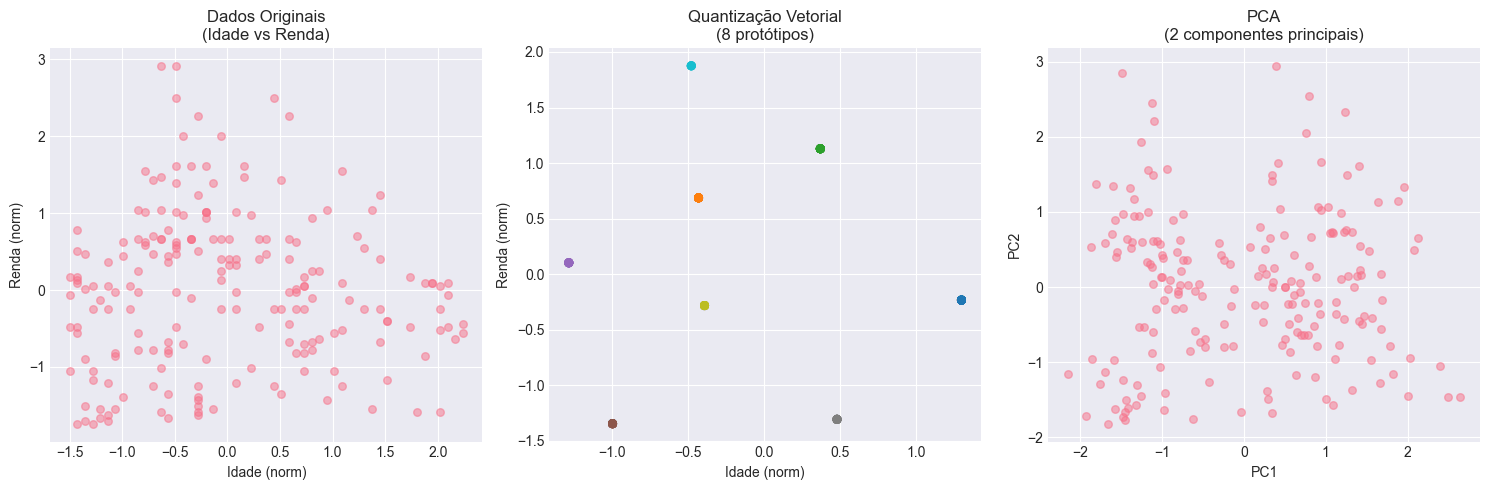

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5, s=30)
axes[0].set_title('Dados Originais\n(Idade vs Renda)')
axes[0].set_xlabel('Idade (norm)')
axes[0].set_ylabel('Renda (norm)')

axes[1].scatter(X_quantized[:, 0], X_quantized[:, 1], 
               c=labels_vq, cmap='tab10', alpha=0.5, s=30)
axes[1].set_title(f'Quantização Vetorial\n({n_clusters_vq} protótipos)')
axes[1].set_xlabel('Idade (norm)')
axes[1].set_ylabel('Renda (norm)')

axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=30)
axes[2].set_title('PCA\n(2 componentes principais)')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

plt.tight_layout()
plt.show()

### Análise Comparativa:

**Quantização Vetorial (K-means):**
- Reduz os dados a protótipos representativos
- Mantém a interpretabilidade das features originais
- Útil para compressão e representação discreta

**PCA:**
- Cria novas features (componentes) que maximizam variância
- Reduz dimensionalidade mantendo informação máxima
- Componentes são combinações lineares das features originais
- Melhor para redução de dimensionalidade contínua

## Questão 4: Agglomerative Clustering com Diferentes Linkages

In [89]:
linkage_methods = ['ward', 'average', 'single', 'complete']
n_clusters_agg = 5

results = {}

for linkage_method in linkage_methods:
    agg_cluster = AgglomerativeClustering(
        n_clusters=n_clusters_agg, 
        linkage=linkage_method
    )
    labels = agg_cluster.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    
    results[linkage_method] = {
        'labels': labels,
        'silhouette': silhouette
    }
    
    print(f"Linkage: {linkage_method:8} | Silhouette Score: {silhouette:.3f}")

Linkage: ward     | Silhouette Score: 0.390
Linkage: average  | Silhouette Score: 0.410
Linkage: single   | Silhouette Score: 0.003
Linkage: complete | Silhouette Score: 0.400


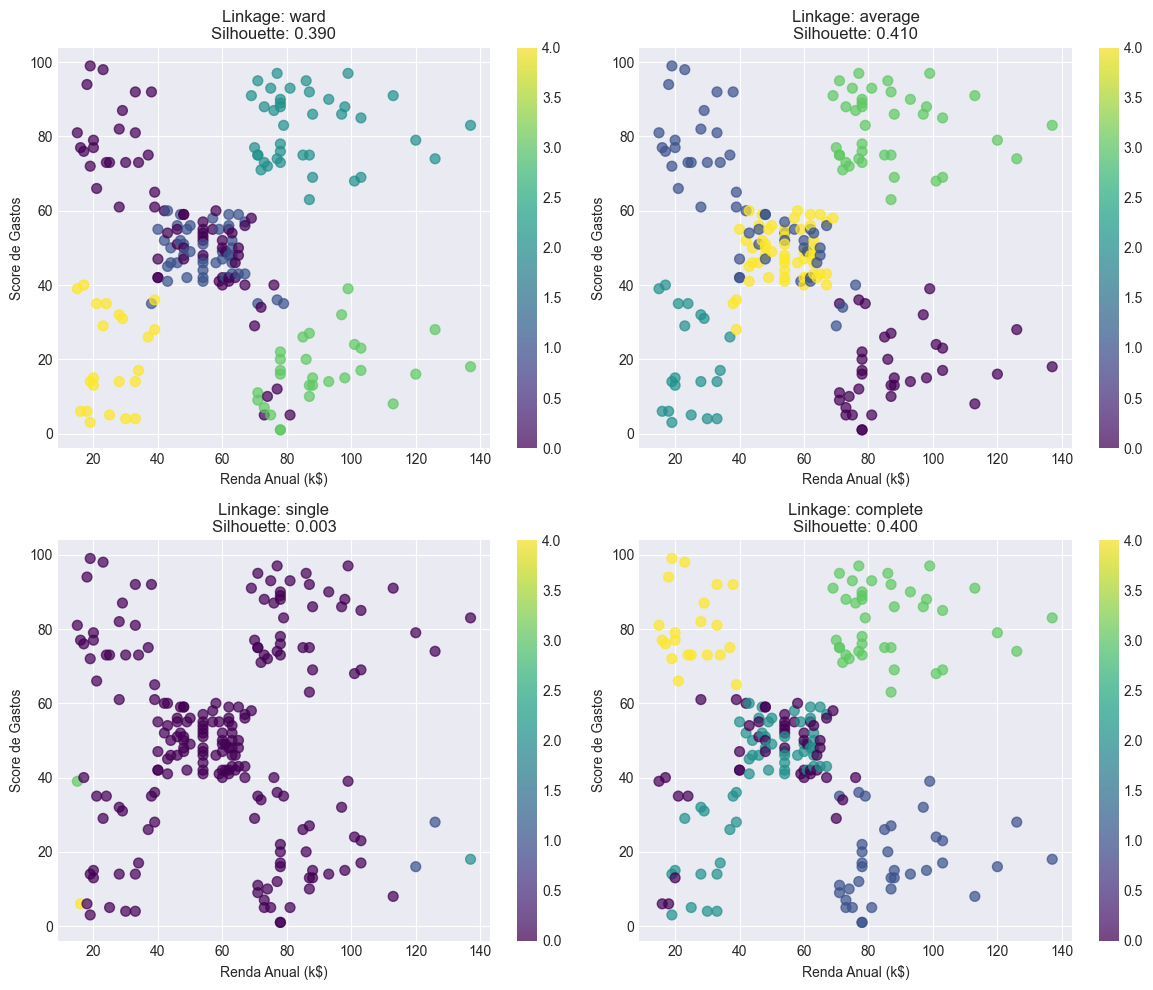

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, linkage_method in enumerate(linkage_methods):
    labels = results[linkage_method]['labels']
    silhouette = results[linkage_method]['silhouette']
    
    scatter = axes[idx].scatter(
        df_mall['Annual Income (k$)'], 
        df_mall['Spending Score (1-100)'],
        c=labels, cmap='viridis', s=50, alpha=0.7
    )
    axes[idx].set_xlabel('Renda Anual (k$)')
    axes[idx].set_ylabel('Score de Gastos')
    axes[idx].set_title(f'Linkage: {linkage_method}\nSilhouette: {silhouette:.3f}')
    plt.colorbar(scatter, ax=axes[idx])

plt.tight_layout()
plt.show()

### Comportamento de cada método de linkage:

**Ward:**
- Minimiza a variância dentro dos clusters
- Tende a criar clusters esféricos e de tamanhos similares
- Melhor para clusters compactos e bem separados

**Average:**
- Usa a distância média entre todos os pares de pontos
- Menos sensível a outliers que single linkage
- Produz clusters de formas mais flexíveis

**Single:**
- Usa a menor distância entre pontos de clusters diferentes
- Pode criar clusters alongados (chaining effect)
- Sensível a pontos de ligação entre grupos

**Complete:**
- Usa a maior distância entre pontos de clusters diferentes
- Tende a criar clusters compactos e bem separados
- Sensível a outliers

## Questão 5: Dendrogramas

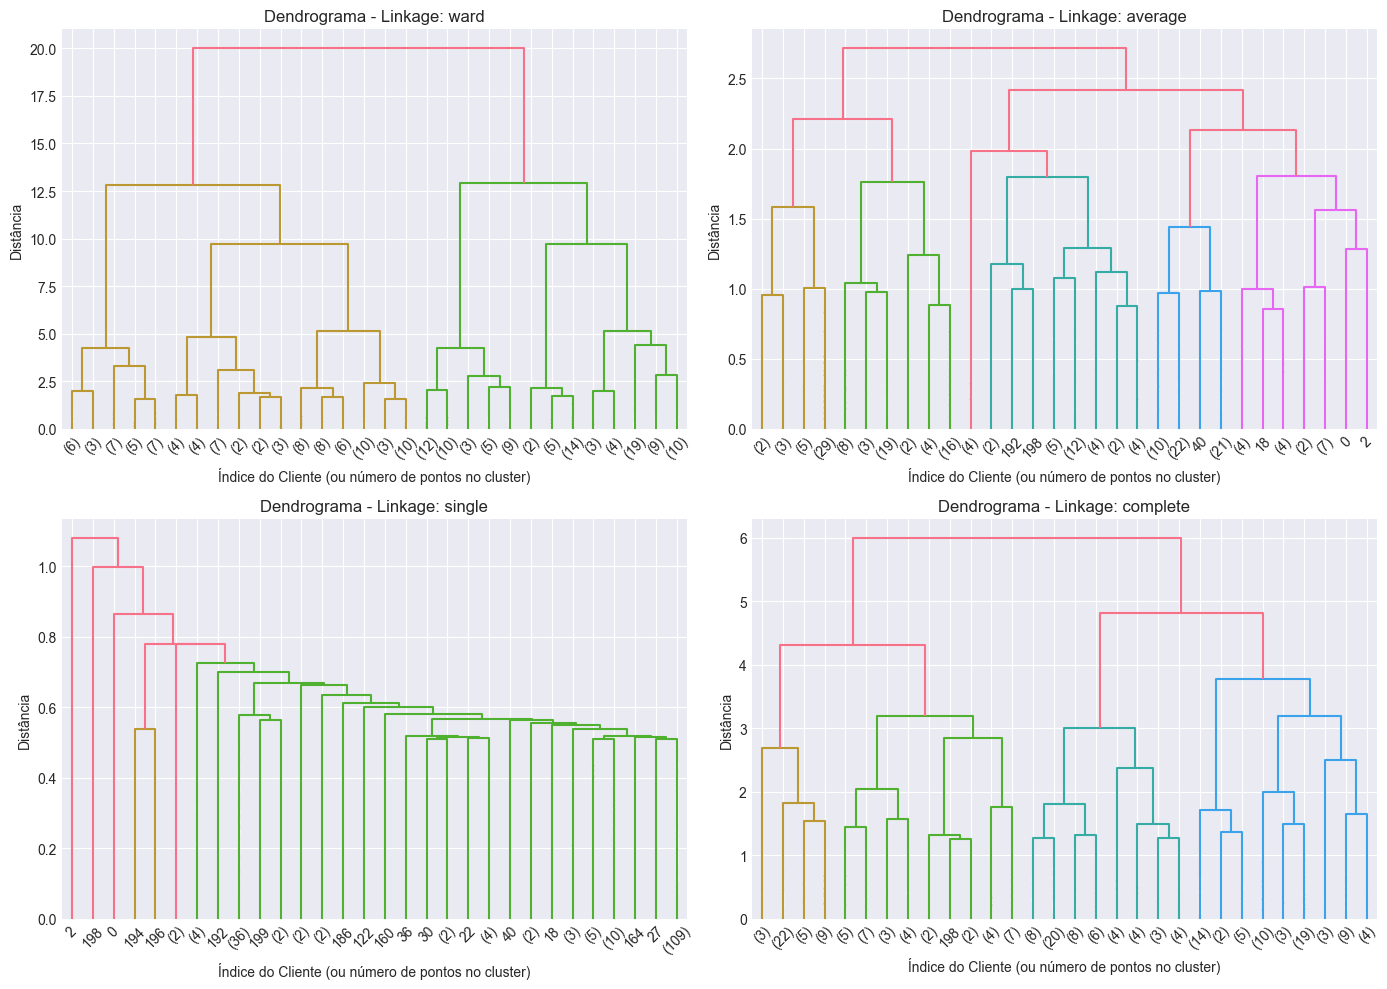

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, linkage_method in enumerate(linkage_methods):
    Z = linkage(X_scaled, method=linkage_method)
    
    dendrogram(Z, 
              ax=axes[idx],
              truncate_mode='lastp',
              p=30,
              leaf_font_size=10,
              show_contracted=True)
    
    axes[idx].set_title(f'Dendrograma - Linkage: {linkage_method}')
    axes[idx].set_xlabel('Índice do Cliente (ou número de pontos no cluster)')
    axes[idx].set_ylabel('Distância')

plt.tight_layout()
plt.show()

### Análise dos Dendrogramas:

Os dendrogramas mostram como os clusters são formados hierarquicamente:

- **Altura dos cortes**: Indica a distância na qual os clusters se juntam
- **Ward e Complete**: Mostram separações mais claras entre grupos
- **Single**: Apresenta fusões graduais (chaining)
- **Average**: Comportamento intermediário

A linha de corte horizontal determina o número de clusters finais.

## Questão 6: Mapa de Calor com Dendrograma

<Figure size 1200x800 with 0 Axes>

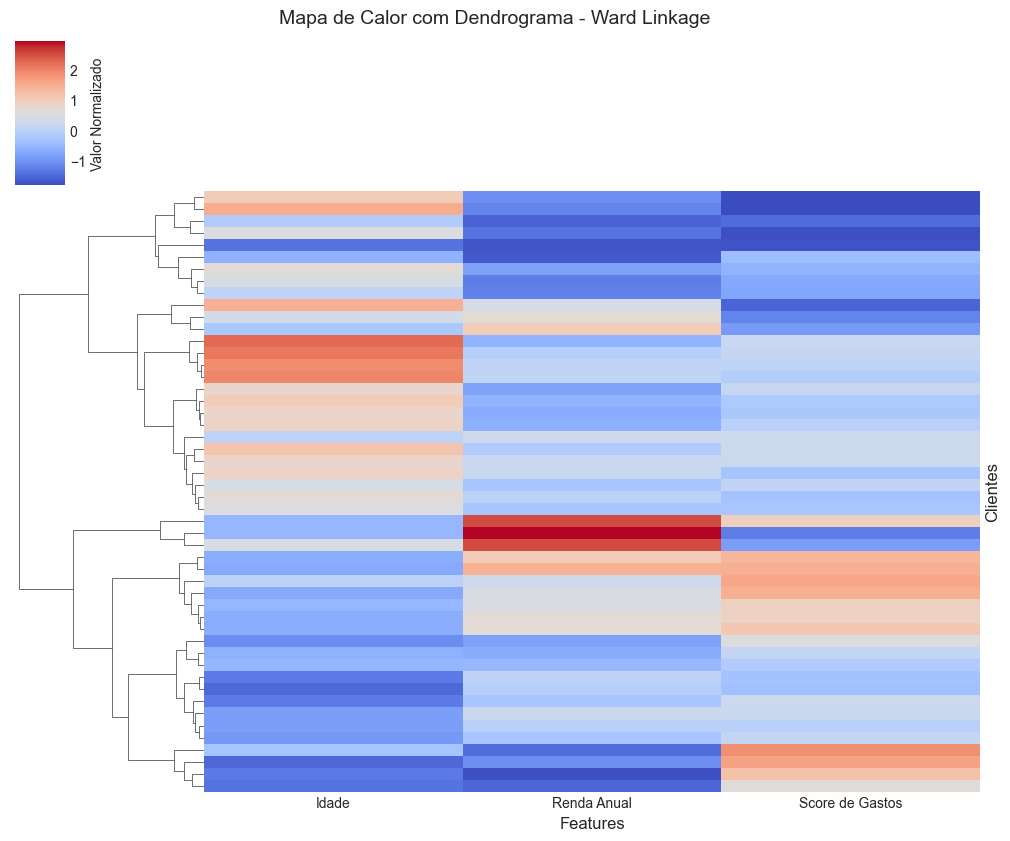

In [92]:
subset_indices = np.random.choice(len(X_scaled), size=50, replace=False)
X_subset = X_scaled[subset_indices]

Z_ward = linkage(X_subset, method='ward')

plt.figure(figsize=(12, 8))

g = sns.clustermap(X_subset, 
                  row_linkage=Z_ward,
                  col_cluster=False,
                  cmap='coolwarm',
                  figsize=(10, 8),
                  cbar_kws={'label': 'Valor Normalizado'},
                  xticklabels=['Idade', 'Renda Anual', 'Score de Gastos'],
                  yticklabels=False)

g.ax_heatmap.set_xlabel('Features', fontsize=12)
g.ax_heatmap.set_ylabel('Clientes', fontsize=12)
plt.suptitle('Mapa de Calor com Dendrograma - Ward Linkage', y=1.02, fontsize=14)
plt.show()

<Figure size 1200x1000 with 0 Axes>

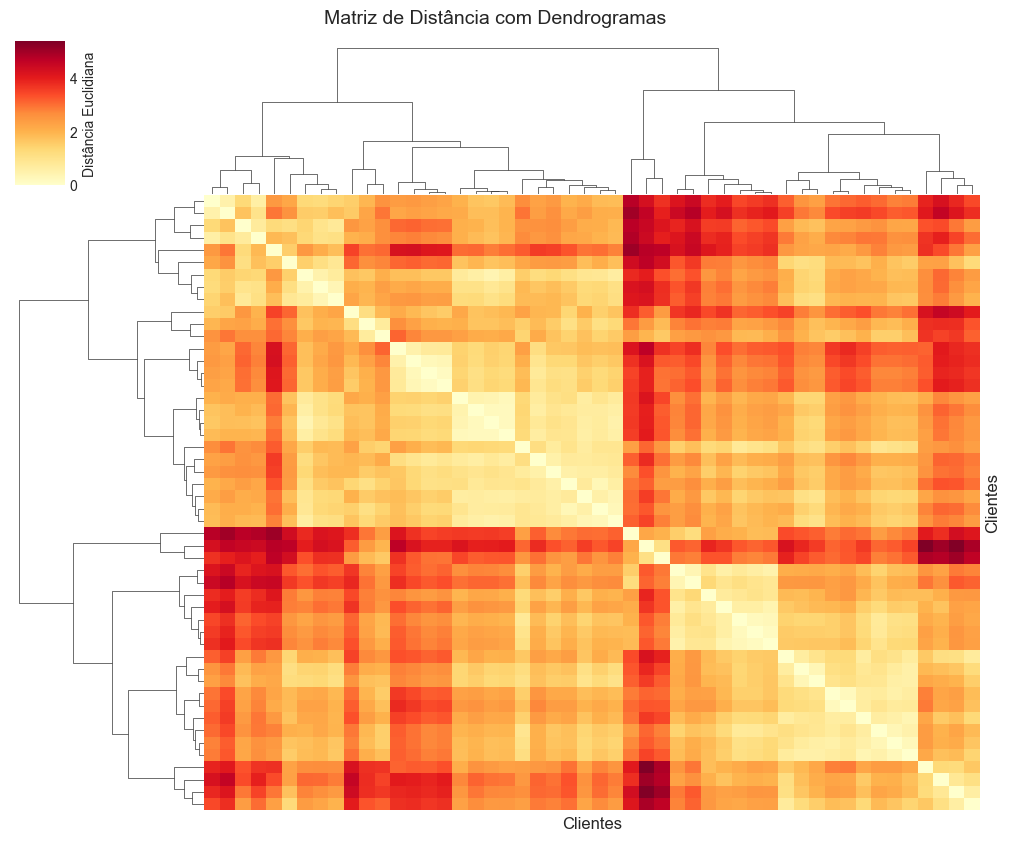

In [93]:
from scipy.spatial.distance import pdist, squareform

distance_matrix = pdist(X_subset, metric='euclidean')
distance_square = squareform(distance_matrix)

plt.figure(figsize=(12, 10))
g = sns.clustermap(distance_square, 
                  row_linkage=Z_ward,
                  col_linkage=Z_ward,
                  cmap='YlOrRd',
                  figsize=(10, 8),
                  cbar_kws={'label': 'Distância Euclidiana'},
                  xticklabels=False,
                  yticklabels=False)

g.ax_heatmap.set_xlabel('Clientes', fontsize=12)
g.ax_heatmap.set_ylabel('Clientes', fontsize=12)
plt.suptitle('Matriz de Distância com Dendrogramas', y=1.02, fontsize=14)
plt.show()

### Análise do Mapa de Calor com Dendrograma:

O mapa de calor com dendrograma permite visualizar:

1. **Agrupamento hierárquico**: O dendrograma mostra como os clientes são agrupados
2. **Padrões nas features**: Cores similares indicam valores próximos
3. **Reordenamento**: Linhas são reordenadas para agrupar clientes similares
4. **Identificação visual**: Blocos de cores similares revelam os clusters

Na matriz de distância, blocos escuros (baixa distância) ao longo da diagonal indicam clusters bem definidos.

## Questão 7: DBSCAN - make_swiss_roll

Aplicar DBSCAN no dataset swiss roll e determinar parâmetros ideais.

In [94]:
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors

n_samples = 1500
X_swiss, color = make_swiss_roll(n_samples, noise=0.1, random_state=42)

X_swiss_2d = X_swiss[:, [0, 2]]

print(f"Shape do Swiss Roll: {X_swiss_2d.shape}")
print(f"Valores de cor (ground truth): {len(np.unique(color))} valores únicos")

Shape do Swiss Roll: (1500, 2)
Valores de cor (ground truth): 1500 valores únicos


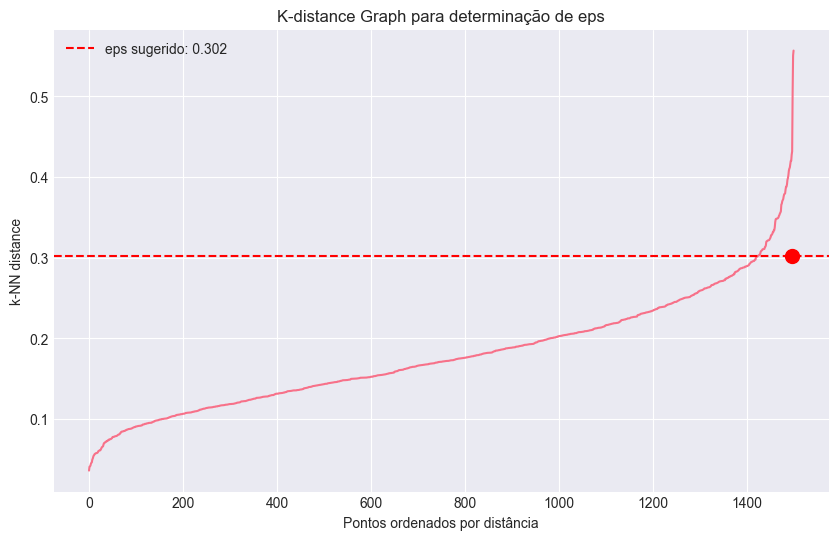

Análise automática do gráfico K-distance:
- Método diferença máxima: eps = 0.432
- Método percentil 95: eps = 0.302
- Valor escolhido (mais conservador): eps = 0.302


In [95]:
k = 5
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_swiss_2d)
distances, indices = nbrs.kneighbors(X_swiss_2d)

distances = np.sort(distances[:, k-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('k-NN distance')
plt.xlabel('Pontos ordenados por distância')
plt.title('K-distance Graph para determinação de eps')
plt.grid(True)

diffs = np.diff(distances.flatten())
knee_idx_diff = np.argmax(diffs)
eps_diff = distances[knee_idx_diff]

eps_percentile = np.percentile(distances, 95)

eps_auto = min(eps_diff, eps_percentile)

plt.axhline(y=eps_auto, color='r', linestyle='--', label=f'eps sugerido: {eps_auto:.3f}')
plt.scatter([knee_idx_diff], [eps_auto], color='red', s=100, zorder=5)
plt.legend()
plt.show()

print(f"Análise automática do gráfico K-distance:")
print(f"- Método diferença máxima: eps = {eps_diff:.3f}")
print(f"- Método percentil 95: eps = {eps_percentile:.3f}")
print(f"- Valor escolhido (mais conservador): eps = {eps_auto:.3f}")

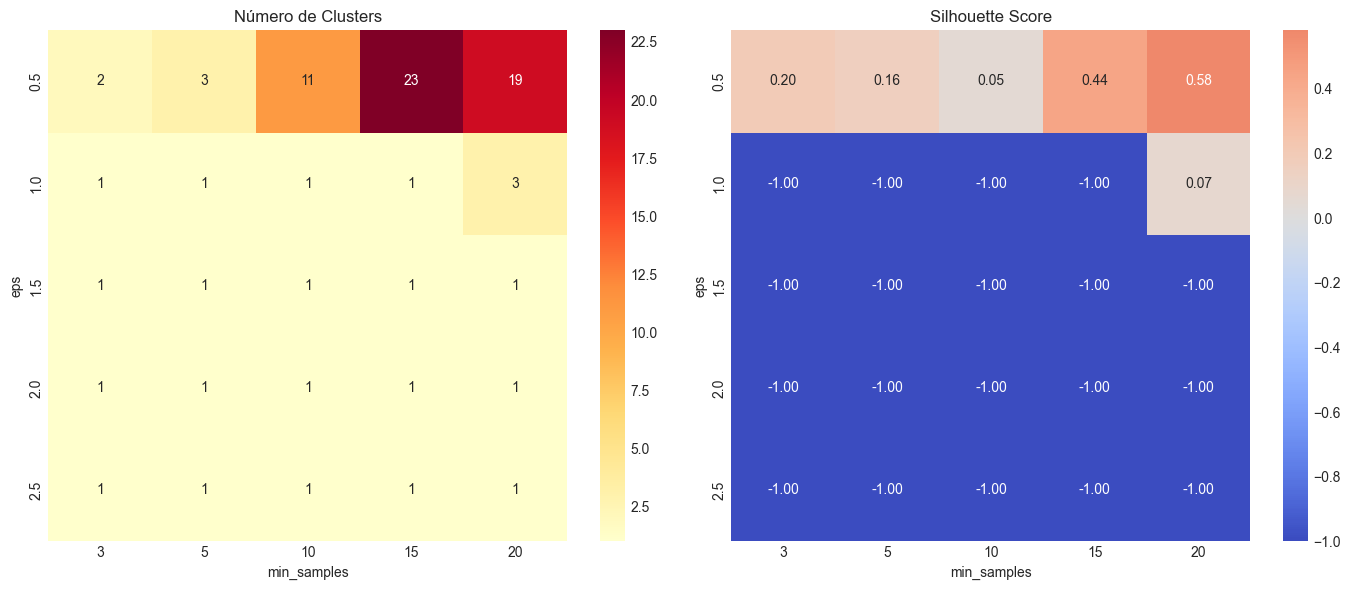

In [96]:
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [3, 5, 10, 15, 20]

silhouette_scores = np.zeros((len(eps_values), len(min_samples_values)))
n_clusters_matrix = np.zeros((len(eps_values), len(min_samples_values)))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_swiss_2d)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_matrix[i, j] = n_clusters
        
        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > 1:
                silhouette_scores[i, j] = silhouette_score(X_swiss_2d[mask], labels[mask])
        else:
            silhouette_scores[i, j] = -1

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(n_clusters_matrix, annot=True, fmt='.0f',
            xticklabels=min_samples_values, 
            yticklabels=eps_values,
            cmap='YlOrRd', ax=axes[0])
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('eps')
axes[0].set_title('Número de Clusters')

sns.heatmap(silhouette_scores, annot=True, fmt='.2f',
            xticklabels=min_samples_values,
            yticklabels=eps_values,
            cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('eps')
axes[1].set_title('Silhouette Score')

plt.tight_layout()
plt.show()

Parâmetros escolhidos: eps=1.5, min_samples=5
Número de clusters: 1
Pontos de ruído: 0 (0.0%)


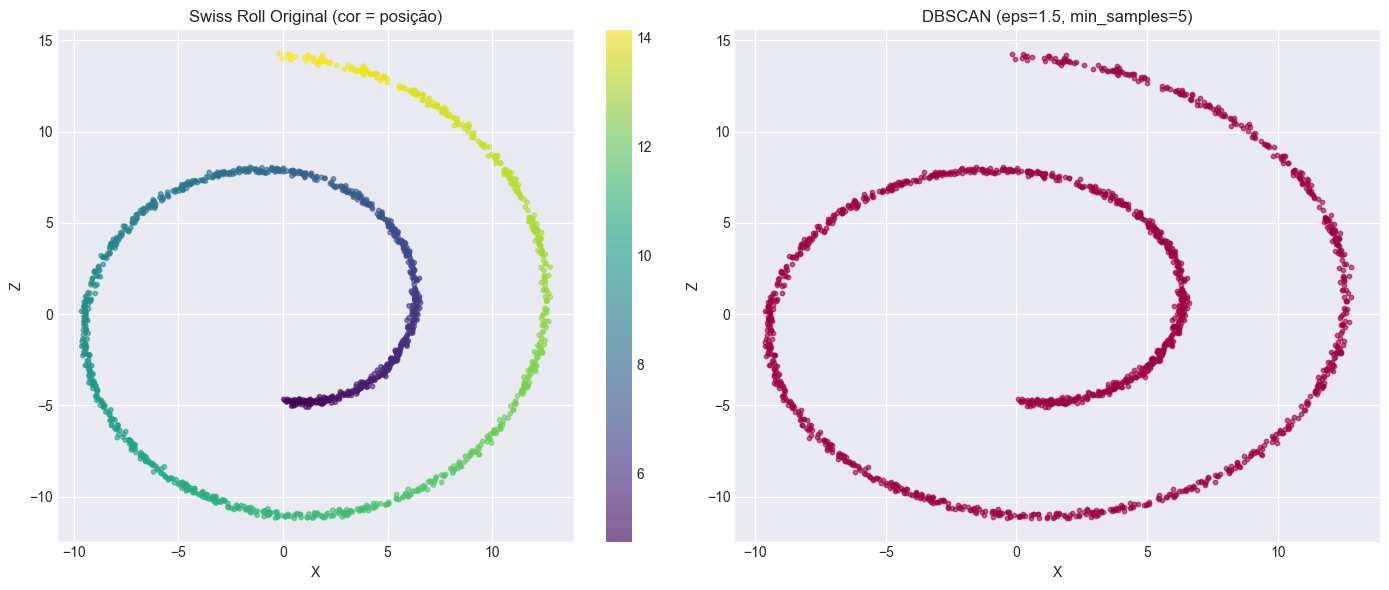

In [97]:
eps_best = 1.5
min_samples_best = 5

dbscan_best = DBSCAN(eps=eps_best, min_samples=min_samples_best)
labels_dbscan = dbscan_best.fit_predict(X_swiss_2d)

n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"Parâmetros escolhidos: eps={eps_best}, min_samples={min_samples_best}")
print(f"Número de clusters: {n_clusters}")
print(f"Pontos de ruído: {n_noise} ({n_noise/len(labels_dbscan)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(X_swiss_2d[:, 0], X_swiss_2d[:, 1],
                          c=color, cmap='viridis', s=10, alpha=0.6)
axes[0].set_title('Swiss Roll Original (cor = posição)')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
plt.colorbar(scatter1, ax=axes[0])

unique_labels = set(labels_dbscan)
colors_dbscan = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors_dbscan):
    if k == -1:
        col = [0, 0, 0, 1]
        marker = 'x'
    else:
        marker = 'o'
    
    class_member_mask = (labels_dbscan == k)
    xy = X_swiss_2d[class_member_mask]
    axes[1].scatter(xy[:, 0], xy[:, 1], c=[col], 
                   marker=marker, s=10 if k != -1 else 20, alpha=0.6)

axes[1].set_title(f'DBSCAN (eps={eps_best}, min_samples={min_samples_best})')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

plt.tight_layout()
plt.show()

## Questão 8: DBSCAN - Mall Customer Segmentation Data

Aplicar DBSCAN no dataset Mall Customer.

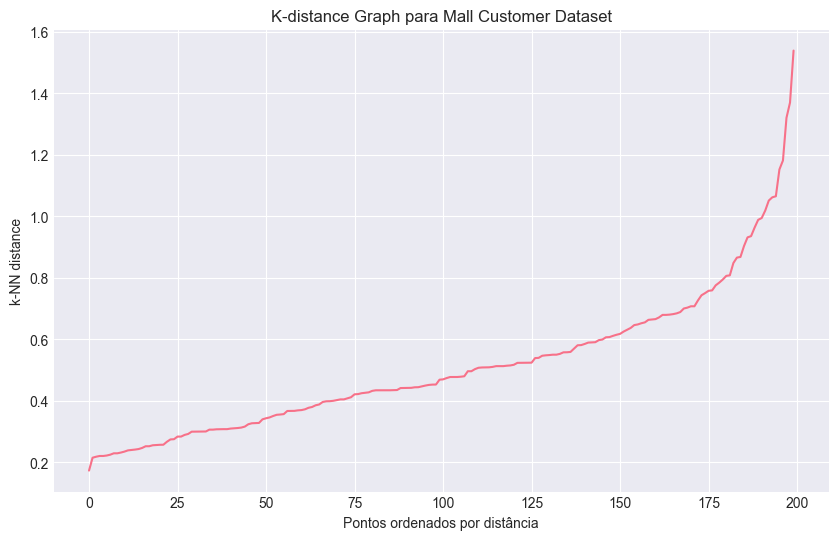

In [98]:
k = 5
neigh_mall = NearestNeighbors(n_neighbors=k)
nbrs_mall = neigh_mall.fit(X_scaled)
distances_mall, indices_mall = nbrs_mall.kneighbors(X_scaled)

distances_mall = np.sort(distances_mall[:, k-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances_mall)
plt.ylabel('k-NN distance')
plt.xlabel('Pontos ordenados por distância')
plt.title('K-distance Graph para Mall Customer Dataset')
plt.grid(True)
plt.show()

In [99]:
eps_mall = 0.5
min_samples_mall = 5

dbscan_mall = DBSCAN(eps=eps_mall, min_samples=min_samples_mall)
labels_dbscan_mall = dbscan_mall.fit_predict(X_scaled)

n_clusters_mall = len(set(labels_dbscan_mall)) - (1 if -1 in labels_dbscan_mall else 0)
n_noise_mall = list(labels_dbscan_mall).count(-1)

print(f"Parâmetros DBSCAN: eps={eps_mall}, min_samples={min_samples_mall}")
print(f"Número de clusters: {n_clusters_mall}")
print(f"Pontos de ruído: {n_noise_mall} ({n_noise_mall/len(labels_dbscan_mall)*100:.1f}%)")

if n_clusters_mall > 1:
    mask = labels_dbscan_mall != -1
    if np.sum(mask) > 1:
        sil_dbscan = silhouette_score(X_scaled[mask], labels_dbscan_mall[mask])
        print(f"Silhouette Score (sem ruído): {sil_dbscan:.3f}")

Parâmetros DBSCAN: eps=0.5, min_samples=5
Número de clusters: 6
Pontos de ruído: 60 (30.0%)
Silhouette Score (sem ruído): 0.482


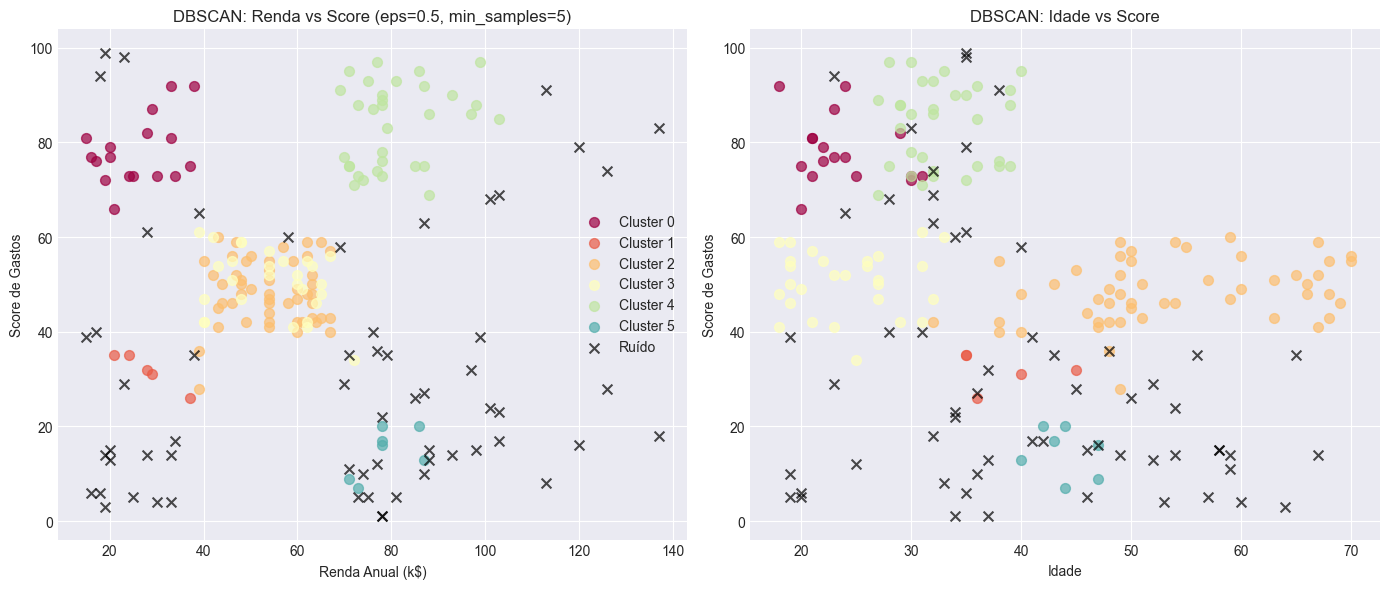

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

unique_labels = set(labels_dbscan_mall)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
        marker = 'x'
        label = 'Ruído'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels_dbscan_mall == k)
    xy = df_mall[class_member_mask]
    axes[0].scatter(xy['Annual Income (k$)'], xy['Spending Score (1-100)'], 
                   c=[col], marker=marker, s=50, alpha=0.7, label=label)

axes[0].set_xlabel('Renda Anual (k$)')
axes[0].set_ylabel('Score de Gastos')
axes[0].set_title(f'DBSCAN: Renda vs Score (eps={eps_mall}, min_samples={min_samples_mall})')
axes[0].legend()

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
        marker = 'x'
    else:
        marker = 'o'
    
    class_member_mask = (labels_dbscan_mall == k)
    xy = df_mall[class_member_mask]
    axes[1].scatter(xy['Age'], xy['Spending Score (1-100)'], 
                   c=[col], marker=marker, s=50, alpha=0.7)

axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Score de Gastos')
axes[1].set_title(f'DBSCAN: Idade vs Score')

plt.tight_layout()
plt.show()

## Questão 9: Comparação de Algoritmos

Comparar K-means (Q2), Agglomerative Ward (Q4) e DBSCAN (Q8) usando ARI, NMI e Silhouette.

In [101]:
labels_kmeans = clusters
labels_ward = results['ward']['labels']

algorithms = ['K-means', 'Agglomerative (Ward)', 'DBSCAN']
all_labels = [labels_kmeans, labels_ward, labels_dbscan_mall]

print("=== Comparação entre Algoritmos ===\n")
print("ARI (Adjusted Rand Index) - Comparação par a par:")
print("-" * 50)

ari_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        ari_matrix[i, j] = adjusted_rand_score(all_labels[i], all_labels[j])
        
ari_df = pd.DataFrame(ari_matrix, index=algorithms, columns=algorithms)
print(ari_df.round(3))

print("\n\nNMI (Normalized Mutual Information) - Comparação par a par:")
print("-" * 50)

nmi_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        nmi_matrix[i, j] = normalized_mutual_info_score(all_labels[i], all_labels[j])
        
nmi_df = pd.DataFrame(nmi_matrix, index=algorithms, columns=algorithms)
print(nmi_df.round(3))

=== Comparação entre Algoritmos ===

ARI (Adjusted Rand Index) - Comparação par a par:
--------------------------------------------------
                      K-means  Agglomerative (Ward)  DBSCAN
K-means                 1.000                 0.773   0.511
Agglomerative (Ward)    0.773                 1.000   0.413
DBSCAN                  0.511                 0.413   1.000


NMI (Normalized Mutual Information) - Comparação par a par:
--------------------------------------------------
                      K-means  Agglomerative (Ward)  DBSCAN
K-means                 1.000                 0.813   0.624
Agglomerative (Ward)    0.813                 1.000   0.584
DBSCAN                  0.624                 0.584   1.000


In [102]:
print("\n\n=== Silhouette Scores ===")
print("-" * 50)

silhouette_scores = []

sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_scores.append(sil_kmeans)
print(f"K-means: {sil_kmeans:.3f}")

sil_ward = silhouette_score(X_scaled, labels_ward)
silhouette_scores.append(sil_ward)
print(f"Agglomerative (Ward): {sil_ward:.3f}")

mask_dbscan = labels_dbscan_mall != -1
if np.sum(mask_dbscan) > 1 and len(set(labels_dbscan_mall[mask_dbscan])) > 1:
    sil_dbscan = silhouette_score(X_scaled[mask_dbscan], labels_dbscan_mall[mask_dbscan])
    print(f"DBSCAN (sem ruído): {sil_dbscan:.3f}")
else:
    sil_dbscan = -1
    print(f"DBSCAN: Não foi possível calcular (clusters insuficientes)")
silhouette_scores.append(sil_dbscan)



=== Silhouette Scores ===
--------------------------------------------------
K-means: 0.417
Agglomerative (Ward): 0.390
DBSCAN (sem ruído): 0.482


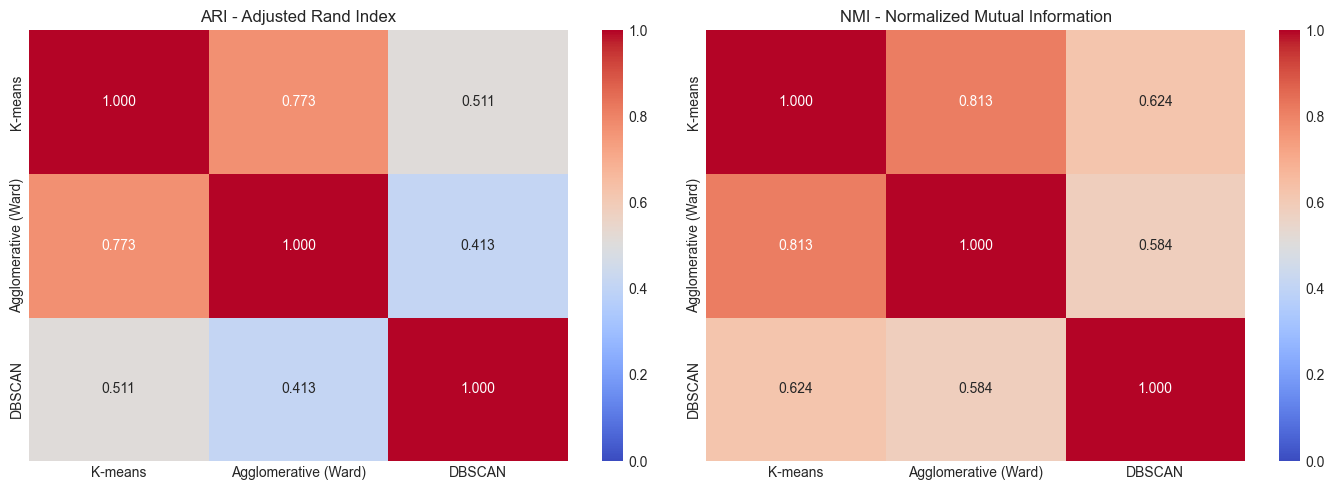

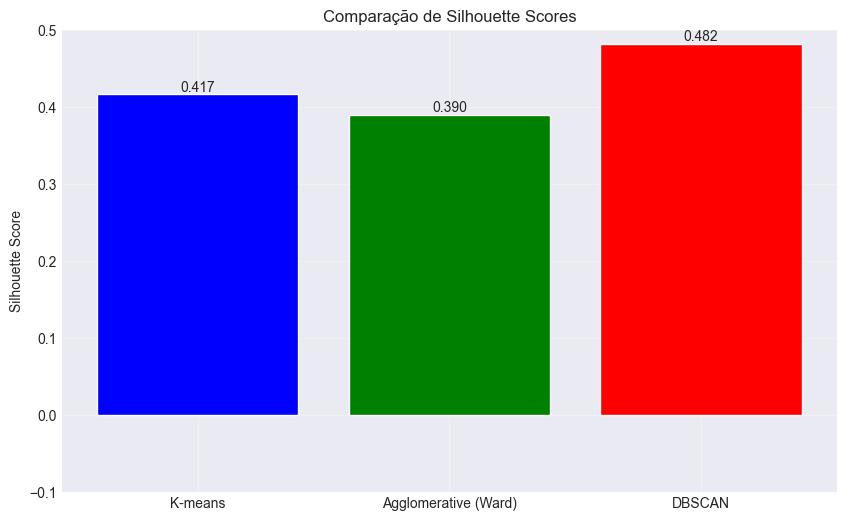


=== Resumo da Comparação ===
1. K-means e Ward têm alta concordância (ARI e NMI altos)
2. DBSCAN diverge dos outros dois (ARI e NMI baixos)
3. K-means tem o melhor Silhouette Score


In [103]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(ari_df, annot=True, fmt='.3f', cmap='coolwarm',
            center=0.5, vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('ARI - Adjusted Rand Index')

sns.heatmap(nmi_df, annot=True, fmt='.3f', cmap='coolwarm',
            center=0.5, vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('NMI - Normalized Mutual Information')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, silhouette_scores, color=['blue', 'green', 'red'])
plt.ylabel('Silhouette Score')
plt.title('Comparação de Silhouette Scores')
plt.ylim(-0.1, 0.5)
for bar, score in zip(bars, silhouette_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Resumo da Comparação ===")
print("1. K-means e Ward têm alta concordância (ARI e NMI altos)")
print("2. DBSCAN diverge dos outros dois (ARI e NMI baixos)")
print("3. K-means tem o melhor Silhouette Score")

## Questão 10: Clustering - Olivetti Faces

Aplicar DBSCAN, K-means e Agglomerative Clustering no dataset Olivetti faces.

In [104]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)
X_olivetti = olivetti.data
y_olivetti = olivetti.target

print(f"Shape do Olivetti Faces: {X_olivetti.shape}")
print(f"Número de pessoas: {len(np.unique(y_olivetti))}")
print(f"Imagens por pessoa: {len(X_olivetti) // len(np.unique(y_olivetti))}")

pca_olivetti = PCA(n_components=50, random_state=42)
X_olivetti_pca = pca_olivetti.fit_transform(X_olivetti)
print(f"\nShape após PCA: {X_olivetti_pca.shape}")
print(f"Variância explicada: {pca_olivetti.explained_variance_ratio_.sum():.3f}")

Shape do Olivetti Faces: (400, 4096)
Número de pessoas: 40
Imagens por pessoa: 10

Shape após PCA: (400, 50)
Variância explicada: 0.874


In [105]:
n_clusters_olivetti = 40

kmeans_olivetti = KMeans(n_clusters=n_clusters_olivetti, random_state=42, n_init=10)
labels_kmeans_olivetti = kmeans_olivetti.fit_predict(X_olivetti_pca)

agg_olivetti = AgglomerativeClustering(n_clusters=n_clusters_olivetti, linkage='ward')
labels_agg_olivetti = agg_olivetti.fit_predict(X_olivetti_pca)

dbscan_olivetti = DBSCAN(eps=15, min_samples=3)
labels_dbscan_olivetti = dbscan_olivetti.fit_predict(X_olivetti_pca)

print("=== Resultados Olivetti Faces ===\n")

ari_kmeans = adjusted_rand_score(y_olivetti, labels_kmeans_olivetti)
nmi_kmeans = normalized_mutual_info_score(y_olivetti, labels_kmeans_olivetti)
sil_kmeans_oli = silhouette_score(X_olivetti_pca, labels_kmeans_olivetti)
print(f"K-means:")
print(f"  ARI: {ari_kmeans:.3f}")
print(f"  NMI: {nmi_kmeans:.3f}")
print(f"  Silhouette: {sil_kmeans_oli:.3f}")

ari_agg = adjusted_rand_score(y_olivetti, labels_agg_olivetti)
nmi_agg = normalized_mutual_info_score(y_olivetti, labels_agg_olivetti)
sil_agg_oli = silhouette_score(X_olivetti_pca, labels_agg_olivetti)
print(f"\nAgglomerative (Ward):")
print(f"  ARI: {ari_agg:.3f}")
print(f"  NMI: {nmi_agg:.3f}")
print(f"  Silhouette: {sil_agg_oli:.3f}")

n_clusters_dbscan = len(set(labels_dbscan_olivetti)) - (1 if -1 in labels_dbscan_olivetti else 0)
n_noise_olivetti = list(labels_dbscan_olivetti).count(-1)
print(f"\nDBSCAN:")
print(f"  Clusters encontrados: {n_clusters_dbscan}")
print(f"  Pontos de ruído: {n_noise_olivetti} ({n_noise_olivetti/len(labels_dbscan_olivetti)*100:.1f}%)")

if n_clusters_dbscan > 1:
    mask_oli = labels_dbscan_olivetti != -1
    ari_dbscan = adjusted_rand_score(y_olivetti[mask_oli], labels_dbscan_olivetti[mask_oli])
    nmi_dbscan = normalized_mutual_info_score(y_olivetti[mask_oli], labels_dbscan_olivetti[mask_oli])
    sil_dbscan_oli = silhouette_score(X_olivetti_pca[mask_oli], labels_dbscan_olivetti[mask_oli])
    print(f"  ARI (sem ruído): {ari_dbscan:.3f}")
    print(f"  NMI (sem ruído): {nmi_dbscan:.3f}")
    print(f"  Silhouette (sem ruído): {sil_dbscan_oli:.3f}")

=== Resultados Olivetti Faces ===

K-means:
  ARI: 0.465
  NMI: 0.775
  Silhouette: 0.207

Agglomerative (Ward):
  ARI: 0.516
  NMI: 0.820
  Silhouette: 0.223

DBSCAN:
  Clusters encontrados: 1
  Pontos de ruído: 0 (0.0%)


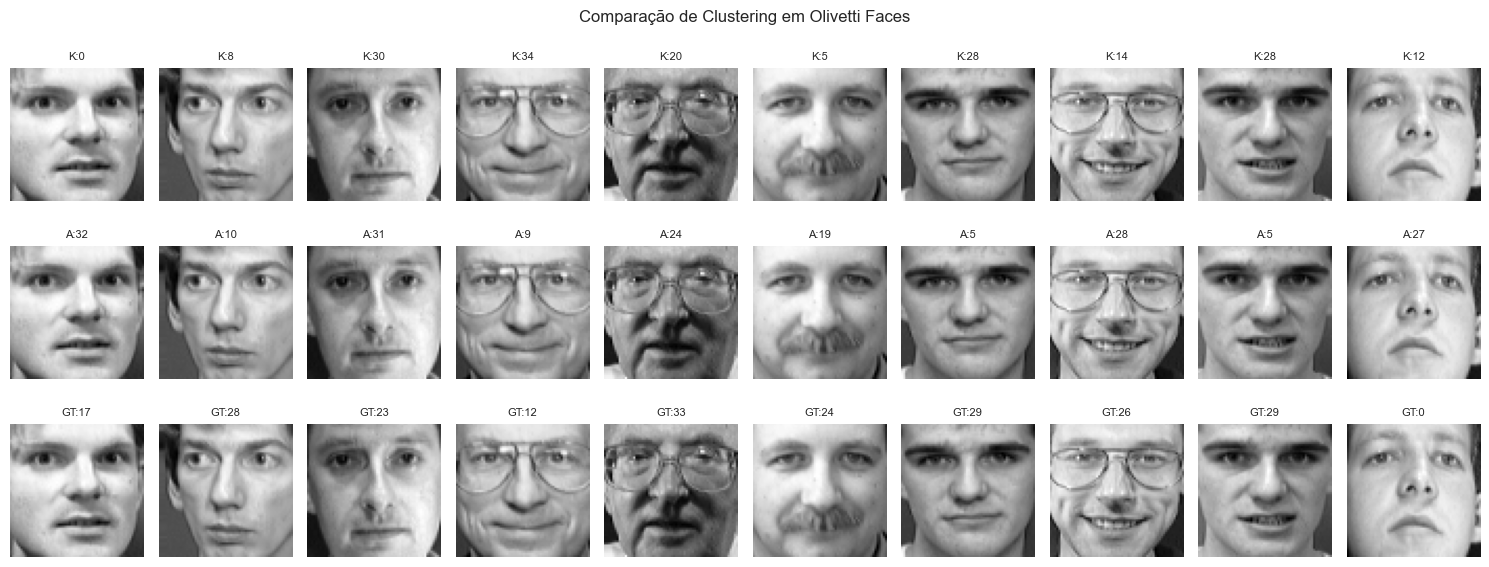

In [106]:
fig, axes = plt.subplots(3, 10, figsize=(15, 6))

sample_indices = np.random.choice(len(X_olivetti), 10, replace=False)

for i, idx in enumerate(sample_indices):
    face = X_olivetti[idx].reshape(64, 64)
    
    axes[0, i].imshow(face, cmap='gray')
    axes[0, i].set_title(f'K:{labels_kmeans_olivetti[idx]}', fontsize=8)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(face, cmap='gray')
    axes[1, i].set_title(f'A:{labels_agg_olivetti[idx]}', fontsize=8)
    axes[1, i].axis('off')
    
    axes[2, i].imshow(face, cmap='gray')
    axes[2, i].set_title(f'GT:{y_olivetti[idx]}', fontsize=8)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('K-means', rotation=90, size=10)
axes[1, 0].set_ylabel('Agglom.', rotation=90, size=10)
axes[2, 0].set_ylabel('Ground\nTruth', rotation=90, size=10)

plt.suptitle('Comparação de Clustering em Olivetti Faces', fontsize=12)
plt.tight_layout()
plt.show()

## Questão 11: Clustering e Tópicos - 20newsgroups

### 11a. K-means sobre o dataset 20newsgroups

In [107]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, 
                                remove=('headers', 'footers', 'quotes'),
                                random_state=42)

print(f"Número de documentos: {len(newsgroups.data)}")
print(f"Categorias: {newsgroups.target_names}")

tfidf = TfidfVectorizer(max_features=1000, max_df=0.5, min_df=2, stop_words='english')
X_news = tfidf.fit_transform(newsgroups.data)
print(f"\nShape da matriz TF-IDF: {X_news.shape}")

Número de documentos: 2034
Categorias: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Shape da matriz TF-IDF: (2034, 1000)


In [108]:
n_clusters_news = 4

kmeans_news = KMeans(n_clusters=n_clusters_news, random_state=42, n_init=10)
labels_kmeans_news = kmeans_news.fit_predict(X_news)

ari_news = adjusted_rand_score(newsgroups.target, labels_kmeans_news)
nmi_news = normalized_mutual_info_score(newsgroups.target, labels_kmeans_news)
sil_news = silhouette_score(X_news, labels_kmeans_news)

print("=== K-means no 20newsgroups ===")
print(f"ARI: {ari_news:.3f}")
print(f"NMI: {nmi_news:.3f}")
print(f"Silhouette: {sil_news:.3f}")

print("\nDistribuição dos clusters:")
cluster_dist = pd.DataFrame({'Cluster': labels_kmeans_news, 
                             'True_Category': newsgroups.target})
print(pd.crosstab(cluster_dist['Cluster'], cluster_dist['True_Category'],
                  rownames=['Cluster'], colnames=['Categoria']))

=== K-means no 20newsgroups ===
ARI: 0.199
NMI: 0.360
Silhouette: 0.014

Distribuição dos clusters:
Categoria    0    1    2    3
Cluster                      
0            1    6  232    0
1          387  160  328  291
2           88    0    2   84
3            4  418   31    2


### 11b. NMF para Determinação de Tópicos

In [109]:
n_topics = 4
nmf = NMF(n_components=n_topics, random_state=42, init='nndsvd')
W = nmf.fit_transform(X_news)
H = nmf.components_

feature_names = tfidf.get_feature_names_out()

print("=== Tópicos identificados com NMF ===\n")
n_top_words = 10

for topic_idx, topic in enumerate(H):
    top_words_idx = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Tópico {topic_idx + 1}:")
    print(" ".join(top_words))
    print()

doc_topics_nmf = W.argmax(axis=1)
print(f"Distribuição de documentos por tópico NMF:")
print(pd.Series(doc_topics_nmf).value_counts().sort_index())

=== Tópicos identificados com NMF ===

Tópico 1:
don think people just like know say ve good time

Tópico 2:
thanks graphics files image file program know format help looking

Tópico 3:
space nasa launch shuttle orbit moon station earth lunar data

Tópico 4:
god jesus bible believe christian atheism does christians faith christ

Distribuição de documentos por tópico NMF:
0    909
1    547
2    363
3    215
Name: count, dtype: int64


### 11c. LDA para Determinação de Tópicos

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1000, max_df=0.5, min_df=2, stop_words='english')
X_counts = cv.fit_transform(newsgroups.data)

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42,
                                learning_method='batch', max_iter=10)
doc_topic_dist = lda.fit_transform(X_counts)

feature_names_cv = cv.get_feature_names_out()

print("=== Tópicos identificados com LDA ===\n")

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names_cv[i] for i in top_words_idx]
    print(f"Tópico {topic_idx + 1}:")
    print(" ".join(top_words))
    print()

doc_topics_lda = doc_topic_dist.argmax(axis=1)
print(f"Distribuição de documentos por tópico LDA:")
print(pd.Series(doc_topics_lda).value_counts().sort_index())

=== Tópicos identificados com LDA ===

Tópico 1:
don like just people think know ve time good make

Tópico 2:
god jesus people does bible believe christian religion say atheism

Tópico 3:
space image edu data graphics nasa program available use file

Tópico 4:
earth space orbit lunar moon mission spacecraft mars surface solar

Distribuição de documentos por tópico LDA:
0    908
1    410
2    582
3    134
Name: count, dtype: int64


## Questão 12: t-SNE - MNIST Dataset

Aplicar t-SNE para visualização do MNIST dataset.

In [111]:
print("Carregando MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')
X_mnist = mnist.data.to_numpy().astype('float32')
y_mnist = mnist.target.to_numpy().astype(int)

n_samples_mnist = 3000
sample_indices = np.random.choice(len(X_mnist), n_samples_mnist, replace=False)
X_mnist_sample = X_mnist[sample_indices]
y_mnist_sample = y_mnist[sample_indices]

X_mnist_sample = X_mnist_sample / 255.0

print(f"Shape da amostra: {X_mnist_sample.shape}")
print(f"Dígitos únicos na amostra: {np.unique(y_mnist_sample)}")

Carregando MNIST...
Shape da amostra: (3000, 784)
Dígitos únicos na amostra: [0 1 2 3 4 5 6 7 8 9]


In [112]:
print("Aplicando t-SNE (pode demorar alguns minutos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_mnist_sample)

print(f"Shape após t-SNE: {X_tsne.shape}")

Aplicando t-SNE (pode demorar alguns minutos)...
Shape após t-SNE: (3000, 2)


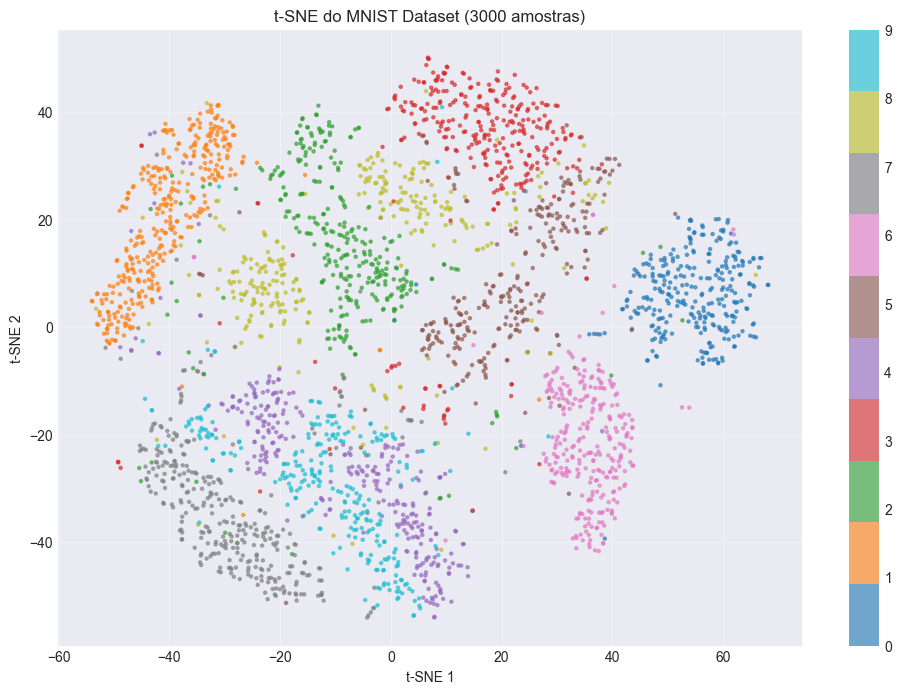


=== Análise do t-SNE ===
O t-SNE conseguiu separar visualmente os diferentes dígitos:
- Clusters bem definidos para cada dígito
- Alguns dígitos próximos (ex: 4 e 9, 3 e 8) devido à similaridade visual
- Preservação da estrutura local dos dados


In [113]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=y_mnist_sample, cmap='tab10', 
                     s=5, alpha=0.6)

plt.colorbar(scatter, ticks=range(10))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE do MNIST Dataset (3000 amostras)')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Análise do t-SNE ===")
print("O t-SNE conseguiu separar visualmente os diferentes dígitos:")
print("- Clusters bem definidos para cada dígito")
print("- Alguns dígitos próximos (ex: 4 e 9, 3 e 8) devido à similaridade visual")
print("- Preservação da estrutura local dos dados")

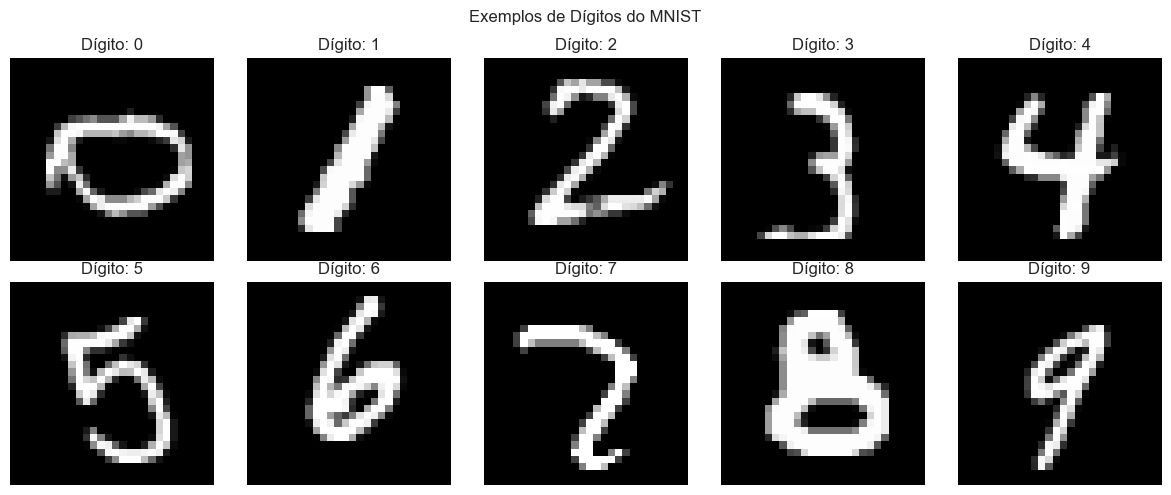

In [114]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit in range(10):
    digit_indices = np.where(y_mnist_sample == digit)[0]
    if len(digit_indices) > 0:
        idx = digit_indices[0]
        img = X_mnist_sample[idx].reshape(28, 28)
        
        axes[digit].imshow(img, cmap='gray')
        axes[digit].set_title(f'Dígito: {digit}')
        axes[digit].axis('off')

plt.suptitle('Exemplos de Dígitos do MNIST', fontsize=12)
plt.tight_layout()
plt.show()